<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [66]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy
import itertools
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LogisticRegression

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn import metrics
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [67]:
# Load the data
house = pd.read_csv('housing.csv')
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [68]:
house.shape

(1460, 81)

In [69]:
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## Dataset

In [70]:
f = open('./data_description.txt', 'r') 
print( f.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

With the assistance of the data description above, we are made aware that MSSubClass should not be in a scale form and for some reason is on a numerical scale from 20-190 with no discernable change in value according to that scale, as such we will need to convert it.

All other features seem to be represented accurately.

In [71]:
remap = {20:'OneStory1946New', 30:'OneStory1945Old', 40:'OneStory', 45:'OneHalfStoryUF',
         50:'OneHalfStoryF', 60:'TwoStory1946New', 70:'TwoStory1945Old', 75:'TwoHalfStory',
         80:'SplitMultiLevel', 85:'SplitFoyer', 90:'Duplex', 120:'OneStoryPUD1946New',
         150:'OneHalfStoryPUD', 160:'TwoStoryPUD1946New', 180:'PUDMultiLevel', 190:'TwoFamConv'}

In [72]:
house.MSSubClass.replace(remap, inplace=True)

After preliminary exploratory data analysis, we need to clean the data to be workable.

## Data Cleaning

We are only interested in residential properties so will search for any non-residential properties and remove from the dataset.


house.MSZoning.value_counts(dropna=False)


In [73]:
house.MSZoning.value_counts(dropna=False)

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [74]:
# Remodel the dataframe to only include the residential properties
house = house[house.MSZoning.isin(['RL','RM','RP','RH'])]

In [75]:
house.shape

(1385, 81)

We can see that 75 rows have been removed.

## Sale Price
Look at the sale price in more detail

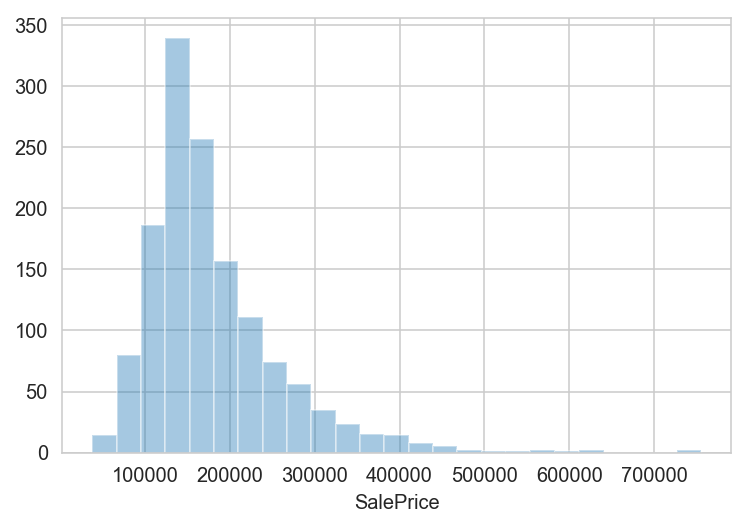

In [76]:
# plot the distribution of sale price
sns.distplot(house.SalePrice, kde=False, bins=25)
plt.show()

We can see that the distribution is skewed right. 

In [77]:
house.SalePrice.describe()

count      1385.000000
mean     180136.283032
std       79906.363281
min       37900.000000
25%      129000.000000
50%      160000.000000
75%      212900.000000
max      755000.000000
Name: SalePrice, dtype: float64

Next I will look at the natural log of the house prices.

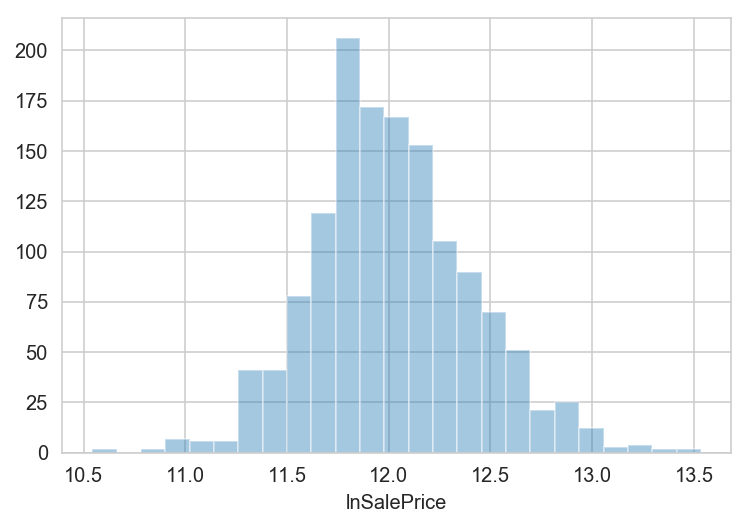

In [78]:
# Create a new feature of the natural log of the sale price
house['lnSalePrice'] = np.log(house.SalePrice+1)

# Plot the distribution
sns.distplot(house.lnSalePrice, kde=False, bins=25)
plt.show()

The distribution of the natural log is more normally distributed so I will use this.



## Additional features

I will create another new feature, the age of the house when it was sold.

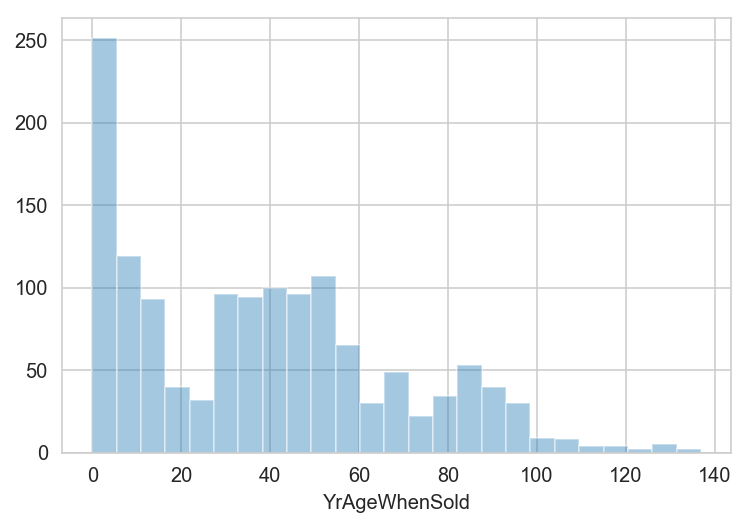

In [79]:
house['YrAgeWhenSold'] = (house.YrSold + (house.MoSold-1)/12.) - house.YearBuilt

# Plot the distribution of the new feature
sns.distplot(house.YrAgeWhenSold, kde=False, bins=25)
plt.show()

The data was collected betwen 2006 and 2010. Let's look at the number of houses sold each year.

In [80]:
house.YrSold.value_counts()

2009    321
2007    313
2006    299
2008    288
2010    164
Name: YrSold, dtype: int64

There is roughly an even number of houses sold between 2006 and 2009. I will use houses sold in 2010 as the test set.

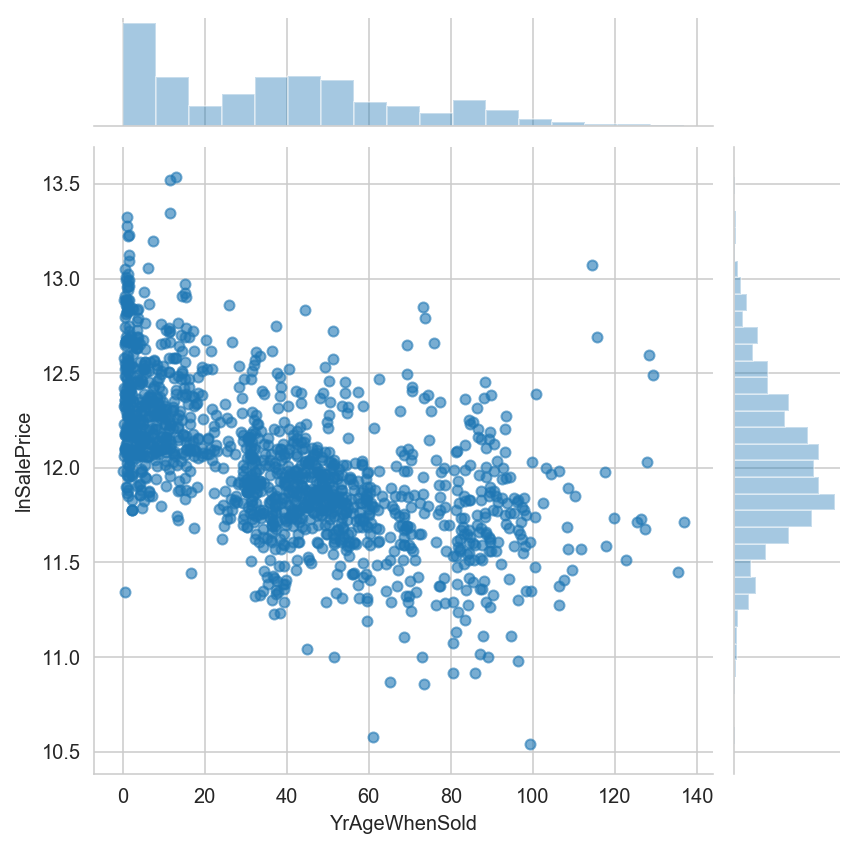

In [81]:
# Plot the age of the house vs. the log sale price
sns.jointplot(house.YrAgeWhenSold, house.lnSalePrice, joint_kws=dict(s=25, alpha=0.6))
plt.show()

There is a relationship between the age of a house when it was sold and it's log sale price. Next look at the houses' liveable area vs. log sale price.

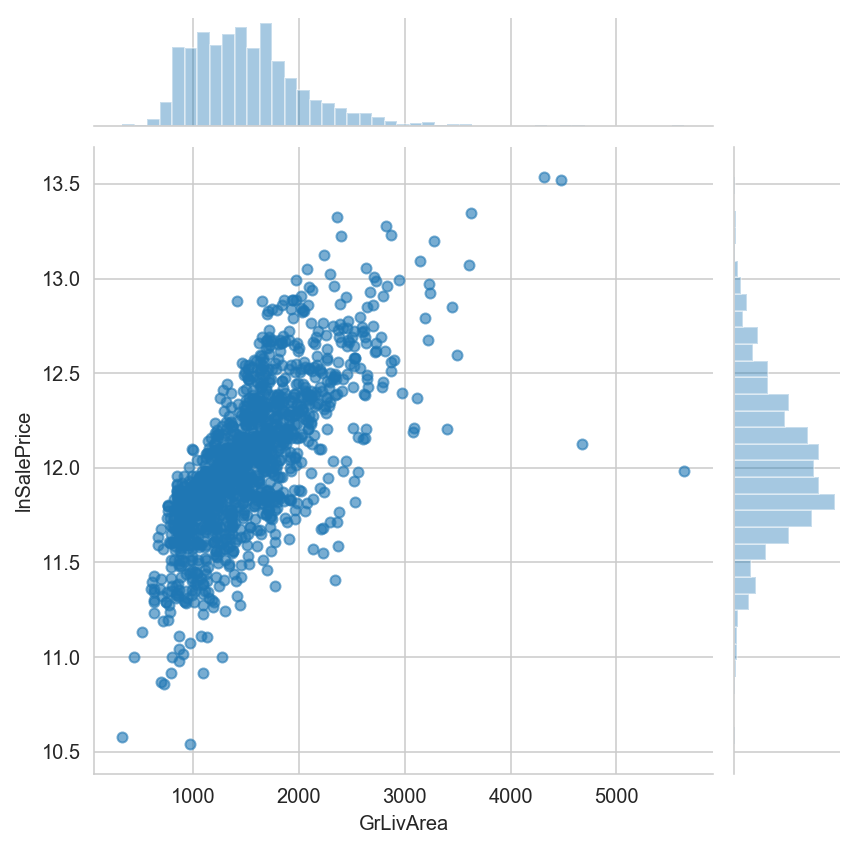

In [82]:
# Plot liveable area vs. the log sale price
sns.jointplot(house.GrLivArea, house.lnSalePrice, joint_kws=dict(s=25, alpha=0.6))
plt.show()

Again there is a clear relationship between the two values. Next look at the distribution of log sale price for each year. I will use boxplots for this.

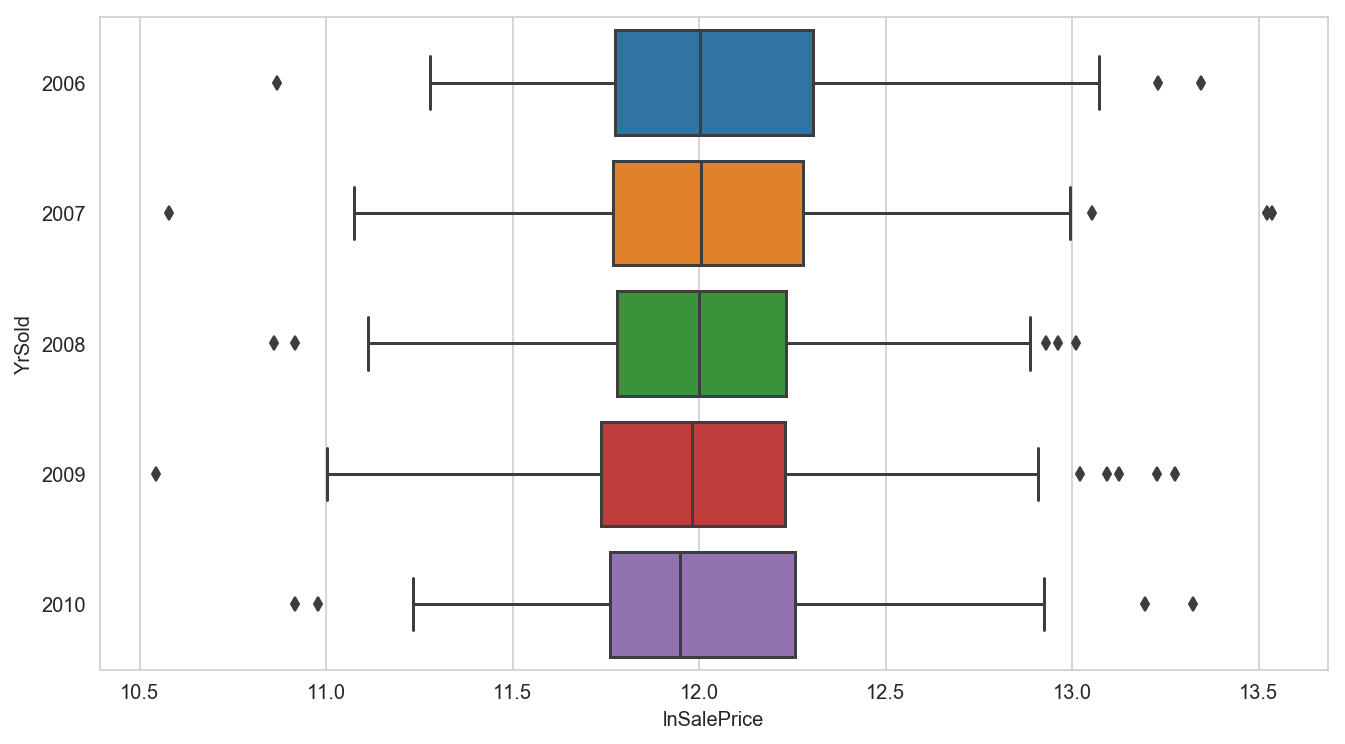

In [83]:
# Plot boxplots of the log sale proce by year
fig, ax = plt.subplots(figsize=(11,6))
sns.boxplot(x='lnSalePrice', y='YrSold', data=house, orient='h', ax=ax)
plt.show()

There is a relationship between the distributions. Now I will look at the distributions of house sales per month.

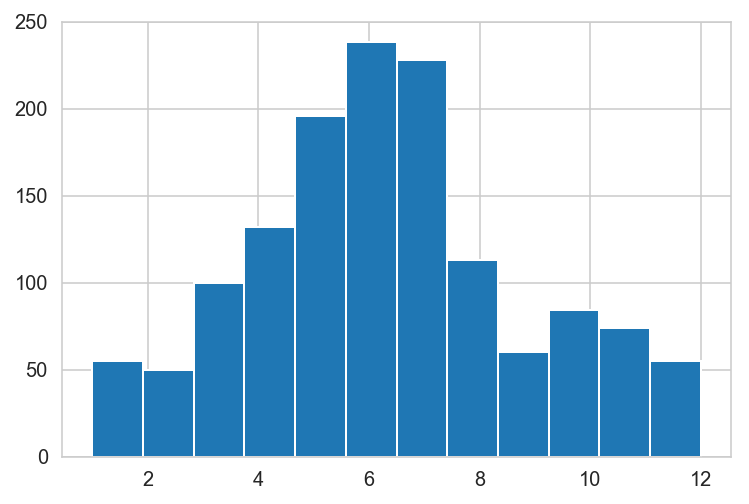

In [84]:
# Plot a histogram of the house sales vs. month sold
house.MoSold.hist(bins=12)
plt.show()

It is evident that the majority of house sales happen during the Summer months. Next look at the distribution of log sale price for each month.

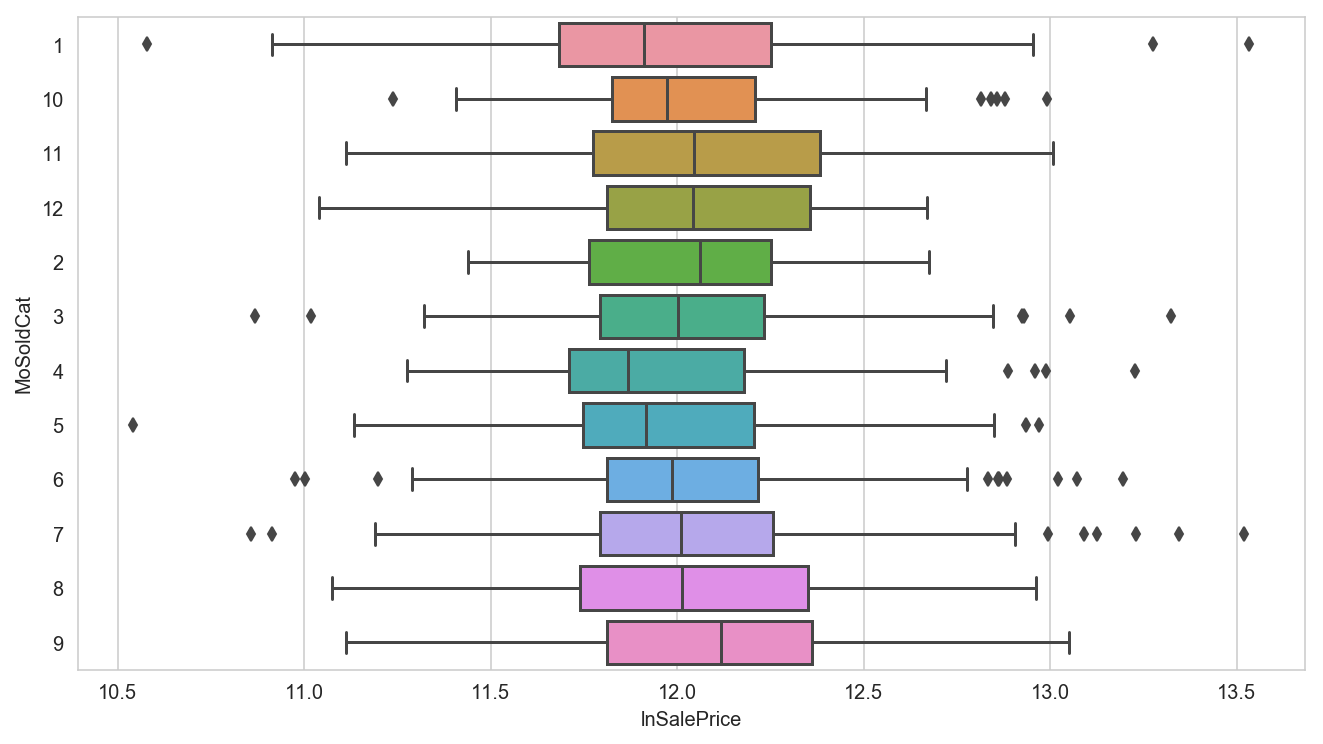

In [87]:
# Convert the values from an integer to a string
house['MoSoldCat'] = house.MoSold.map(lambda x: str(x))

# Plot boxplots of the log sale proce by month
fig, ax = plt.subplots(figsize=(11,6))
sns.boxplot(x='lnSalePrice',y='MoSoldCat', data=house, orient='h', ax=ax)
plt.show()

There is an effect here which will be explored further on. Next I will look at the features in more detail, starting by looking for null values.

In [88]:
house.isnull().sum()[house.isnull().sum() > 0]

LotFrontage      251
Alley           1320
MasVnrType         5
MasVnrArea         5
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      641
GarageType        79
GarageYrBlt       79
GarageFinish      79
GarageQual        79
GarageCond        79
PoolQC          1378
Fence           1108
MiscFeature     1333
dtype: int64

There are quite a few features will null values. There are a mix of continuous and categorical values.

For the categorical features I will replace the null values with 'None' as this is is what the null values refer to according to the data description file.

For the the continuous features many can be replaces with 0 as this is are meant to refer to.

I will write a function to replace the null values for both the continuous and categorical features. But I will drop the following features -

Id
Electrical
PoolQC
The Id is just a unique identifier for each house and has no value for predicting house prices. For Electrical here is only one value missing so I will remove this row. Final I will drop PoolQC as there are only a small percentage of properties with pools.

In [89]:
# Define function to replace null values
def replace_null(df, col, fillval='None'):
    
    df.loc[df[col].isnull(), col] = fillval
    
    return df

In [90]:
# Identify the features to be amended
none_cols = ['GarageType','GarageFinish','GarageQual','GarageCond','Fence',
                  'FireplaceQu','BsmtFinType2','BsmtFinType1','BsmtExposure',
                  'BsmtCond','BsmtQual','MasVnrType','MiscFeature']
zero_cols = ['Alley','LotFrontage','MasVnrArea']
drop_rows = ['Electrical']
drop_cols = ['PoolQC','Id']

In [91]:
# Apply the function to the columns
for col in none_cols:
    house = replace_null(house, col, fillval='None')
    
for col in zero_cols:
    house = replace_null(house, col, fillval=0.)
    
for col in drop_rows:
    house = house[~house[col].isnull()]
    
for col in drop_cols:
    house.drop(col, axis=1, inplace=True)

/Volumes/ravi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


I will recheck the the dataframe to see that the null values have been replaced.

In [92]:
house.isnull().sum()[house.isnull().sum() > 0]

GarageYrBlt    79
dtype: int64

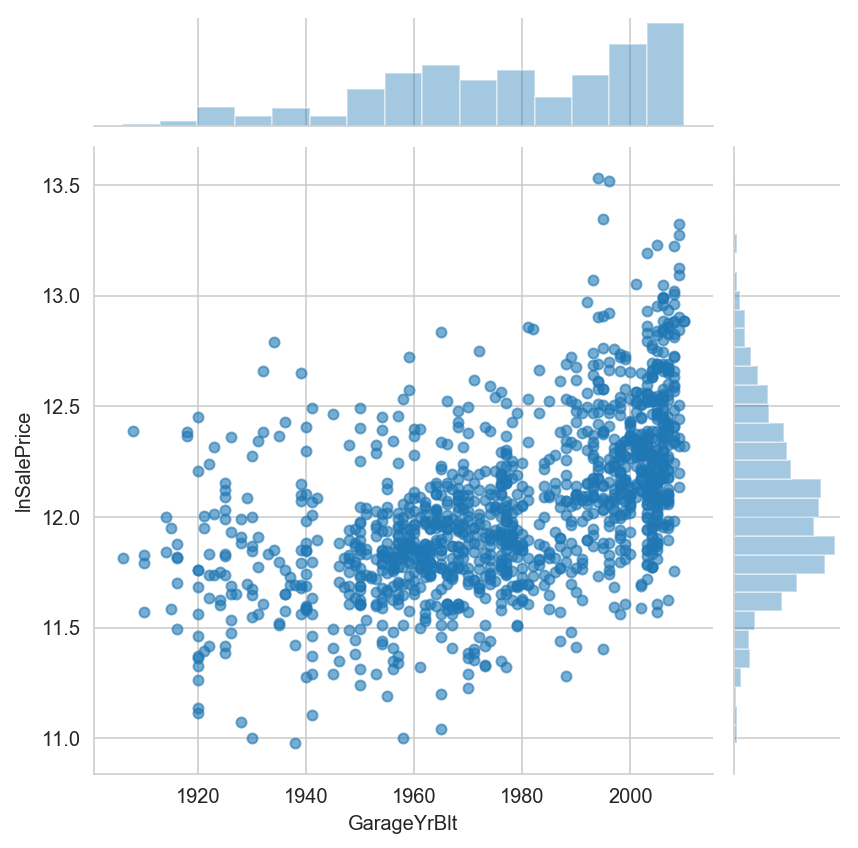

In [93]:
# Plot GarageYrBlt vs. the log sale price
sns.jointplot(house.GarageYrBlt, house.lnSalePrice, joint_kws=dict(s=25, alpha=0.6))
plt.show()

There is a relationship between the the feature and the log sale price but I will drop it due to the number of null values.


In [94]:
# Drop the colums with GarageYrBlt
house.drop('GarageYrBlt', axis=1, inplace=True)

There are a number of features that are redundant, an example is MSSubClass. From the data description file -

MSSubClass: Identifies the type of dwelling involved in the sale.

20 1-STORY 1946 & NEWER ALL STYLES
30 1-STORY 1945 & OLDER
40 1-STORY W/FINISHED ATTIC ALL AGES
45 1-1/2 STORY - UNFINISHED ALL AGES
50 1-1/2 STORY FINISHED ALL AGES
60 2-STORY 1946 & NEWER
70 2-STORY 1945 & OLDER
75 2-1/2 STORY ALL AGES
80 SPLIT OR MULTI-LEVEL
85 SPLIT FOYER
90 DUPLEX - ALL STYLES AND AGES
120 1-STORY PUD (Planned Unit Development) - 1946 & NEWER
150 1-1/2 STORY PUD - ALL AGES
160 2-STORY PUD - 1946 & NEWER
180 PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
190 2 FAMILY CONVERSION - ALL STYLES AND AGES
A lot of this information is identified in other features and so I will drop it alond with BldgType and HouseStyle.

In [95]:
# Drop the feature columns
house.drop(['MSSubClass', 'BldgType', 'HouseStyle'], axis=1, inplace=True)

For a feature to be of any value there has to variance in its values. I will find the proportion of the majority class and if it id greater than 95% I will drop the feature.



In [96]:
# Define a function to calculate the proportion of the majority class
def prop_majority(df, col):
    
    max_count = df[col].value_counts().max()
    
    return float(max_count)/df.shape[0]

In [97]:
# Apply the function to the dataframe
props = [[col,prop_majority(house, col)] for col in house.columns]

# Convert the proportions into a dataframe
props = pd.DataFrame(props, columns=['feature','majority'])

# Display the columns with a majority class greater than 95%
props[props.majority > 0.95]

,feature,majority
3,Street,0.997110
4,Alley,0.953035
7,Utilities,0.999277
12,Condition2,0.989884
18,RoofMatl,0.981214
35,Heating,0.977601
41,LowQualFinSF,0.984104
48,KitchenAbvGr,0.951590
64,3SsnPorch,0.982659
66,PoolArea,0.994942


There are quite a few features showing little variance so I will drop these features columns next. From looking at the features we can see some may provide some interesting insights but for this project they will be removed for simplicity.

In [98]:
# Identify the columns to be dropped
prop_cols = props[props.majority > 0.95].feature.values

# Drop the columns from the dataframe
house = house.drop(prop_cols, axis=1)

I will combine the features BsmtFinSF1 and BsmtFinSF2 as they both refer to the size of the basement in the same property.



In [99]:
house['BsmtFinSF'] = house.BsmtFinSF1 + house.BsmtFinSF2

# Drop some additional features
house.drop(['Exterior2nd','BsmtFinType2','TotalBsmtSF','BsmtFinSF1',
        'BsmtFinSF2'], axis=1, inplace=True)

In [100]:
# Rename some features as they cannot start with a number
house.rename(columns={'2ndFlrSF':'SecondFlrSF', '1stFlrSF':'FirstFlrSF'}, inplace=True)

In [101]:
# Identified changable features relating to quality/condition
changeable = ['OverallCond','RoofStyle','Exterior1st','ExterCond',
              'BsmtCond','HeatingQC','CentralAir','Electrical',
              'GarageFinish','GarageCond','PavedDrive','Functional',
              'OverallQual','ExterQual','BsmtQual','GarageQual','KitchenQual',
              'FireplaceQual','YearRemodAdd']

The fixed features are mostly categorical so there will be a lot of additional columns created.



In [102]:
# Identified fixed features
fixed = '''
lnSalePrice ~ MSZoning + LotFrontage + LotArea + LotShape + LandContour + LotConfig + 
LandSlope + Neighborhood + Condition1 + 
YearBuilt + MasVnrType + MasVnrArea + Foundation + 
BsmtExposure + BsmtFinType1 + BsmtUnfSF + FirstFlrSF + SecondFlrSF + 
GrLivArea + BsmtFullBath + BsmtHalfBath + FullBath + HalfBath + BedroomAbvGr + 
TotRmsAbvGrd + Fireplaces + GarageType + SaleCondition + SaleType +
GarageCars + GarageArea + WoodDeckSF + OpenPorchSF + 
EnclosedPorch + ScreenPorch + Fence + C(YrSold) + C(MoSold) + YrAgeWhenSold + BsmtFinSF -1
'''

I will need to identify the indices for the houses sold in 2010. This will be used for seperating training and test sets.

In [103]:
recent_indices = house.YrSold == 2010

In [104]:
# Use Patsy formula to create X, y for modelling
y, X = patsy.dmatrices(fixed, data=house, return_type='dataframe')
y = y.values.ravel()

# Show the shapes of the features
print(y.shape, X.shape)

(1384,) (1384, 126)


In [105]:
# Standardise the X before splitting into training and test sets
ss = StandardScaler()
Xs = ss.fit_transform(X)

In [106]:
# Create training and test sets
X_train, X_test = Xs[~recent_indices.values], Xs[recent_indices.values]
y_train, y_test = y[~recent_indices.values], y[recent_indices.values]

In [107]:
# Convert X_train and X_test to data frames
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

# Show the shapes of the train and test sets
print(X_train.shape, X_test.shape)

(1220, 126) (164, 126)


I will use Lasso to do some feature selection early due to the row-to-col dimensionality.

Using LassoCV I will identify a subset of useful features and find the best regularisation strength.

In [108]:
# Define the model
lasso_cv = LassoCV(n_alphas=300, cv=10, verbose=1)

# Fit the model 
lasso_cv.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=300, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=1)

I will plot the mean CV Mean Square Error (MSE) against the alpha values.

In [109]:
# Identify the mean MSE, standard deviations and alpha values
mean_mse = np.array([np.mean(x) for x in lasso_cv.mse_path_])
std_mse = np.array([np.std(x) for x in lasso_cv.mse_path_])
alphas = lasso_cv.alphas_

# Create values for identify bands for the standard deviation
std_plus = mean_mse+std_mse/2.
std_minus = mean_mse-std_mse/2.

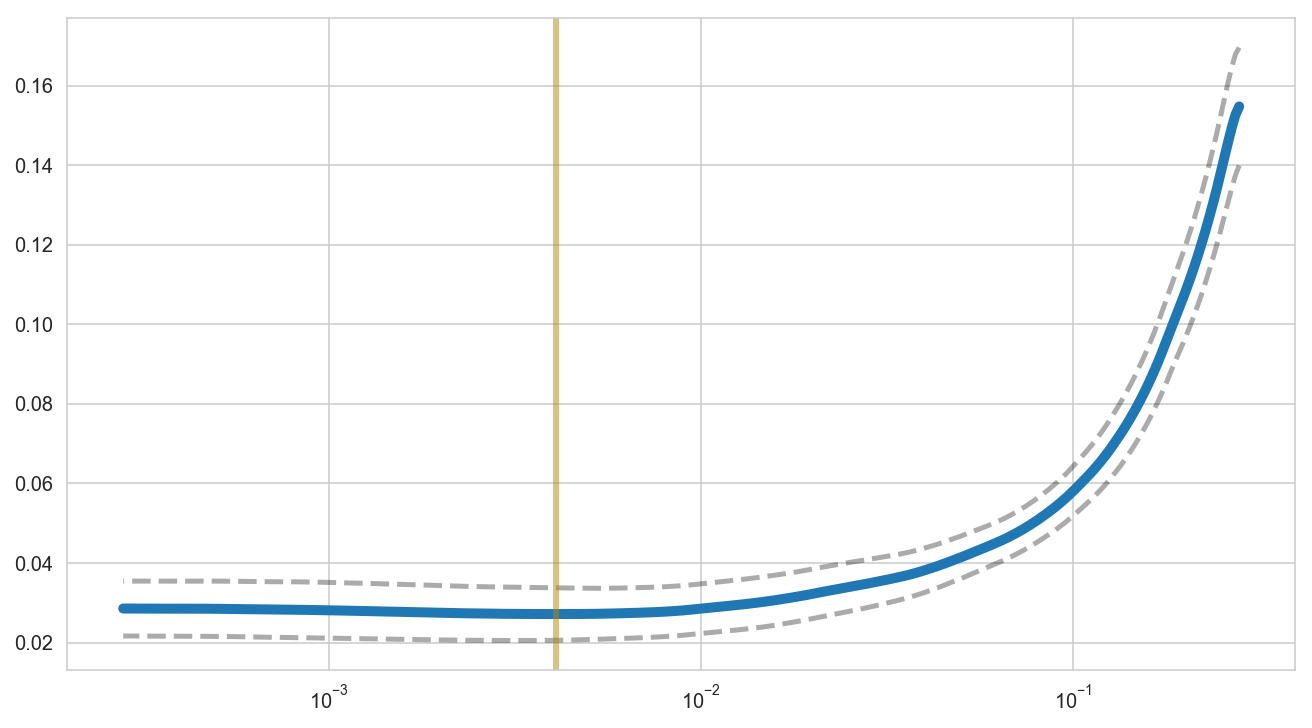

In [119]:
# Plot the mean MSE vs alpha values
fig, ax = plt.subplots(figsize=(11,6))
ln_alphas = np.log(alphas)
ax.plot(alphas, mean_mse, lw=5)
ax.plot(alphas, std_plus, lw=2.5, ls='dashed', c='black', alpha=0.33)
ax.plot(alphas, std_minus, lw=2.5, ls='dashed', c='black', alpha=0.33)
min_mse = np.min(mean_mse)
best_alpha = np.where(mean_mse == min_mse)[0][-1]
ax.axvline(x=alphas[best_alpha], lw=3, c='darkgoldenrod', alpha=0.5)
plt.xscale('log')

plt.show()

The best alpha value is identified in the plot above as the gold vertical line.

In [120]:
print('The best alpha value was found to be ', lasso_cv.alpha_)
print("mean of mean sqaure error is: ",mean_mse.mean())

The best alpha value was found to be  0.004076941887813188
mean of mean sqaure error is:  0.04146148889972413


In [121]:
# Display the features and coefs into a dataframe sorted by magnitude
lasso_feat = pd.DataFrame(dict(feature=X.columns, coef=lasso_cv.coef_, abscoef=np.abs(lasso_cv.coef_)))
lasso_feat.sort_values('abscoef', inplace=True, ascending=False)
lasso_feat[lasso_feat.coef != 0.]

,feature,coef,abscoef
110,GrLivArea,0.132673,0.132673
118,GarageCars,0.055023,0.055023
30,Neighborhood[T.NridgHt],0.044379,0.044379
105,YearBuilt,0.034992,0.034992
117,Fireplaces,0.030979,0.030979
20,Neighborhood[T.Crawfor],0.028614,0.028614
36,Neighborhood[T.StoneBr],0.025342,0.025342
124,YrAgeWhenSold,-0.023932,0.023932
62,BsmtFinType1[T.None],-0.022879,0.022879
21,Neighborhood[T.Edwards],-0.020769,0.020769


Lasso has selected 69 features with is quite a lot, the rest of the features were reduced to 0. Looking at the top features it can be seen that they make sense - livable area, cars in garage, neighborhood, age when sold, fireplaces, etc..

These coefficients are a bit hard to interpret:

They are in terms of standard deviations of the predictor.
The target is in log terms (orders of magnitude)
So basically "for a 1 standard deviation increase in this predictor coefficient, there will be x increase in orders of magnitude of the sale price"

Using the best alpha value I will fit to a Lasso model.

In [122]:
# Define the model
best_lasso = Lasso(alpha=lasso_cv.alpha_)

# Fit the model
best_lasso.fit(X_train, y_train)

Lasso(alpha=0.004076941887813188, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [123]:
# Use the test set on the trained model
best_lasso.score(X_test, y_test)

0.8863498569186207

The R2 score is 0.88 or 88% of the variance in price can be explained. This is a good value.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

From the best model we can get the residuals.

In [124]:
# Gett the residuals for training and testing, in terms of dollars.
train_resids = np.exp(y_train) - np.exp(best_lasso.predict(X_train))
test_resids = np.exp(y_test) - np.exp(best_lasso.predict(X_test))

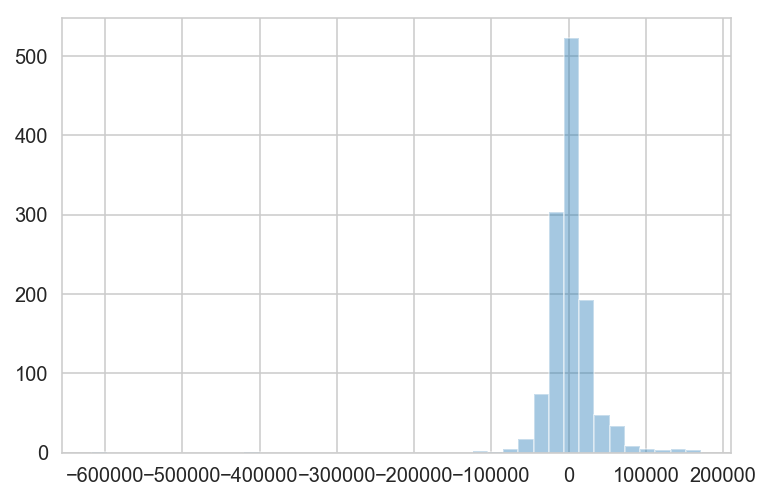

In [125]:
# Plot a distribution of the training residuals
sns.distplot(train_resids, kde=False, bins=40)
plt.show()

From the plot we can see that there is an outlier around -600000. Lets identify it.

In [126]:
print('The outlier value is ', train_resids.min())

The outlier value is  -616563.4776728507


Now let's plot the test residuals.

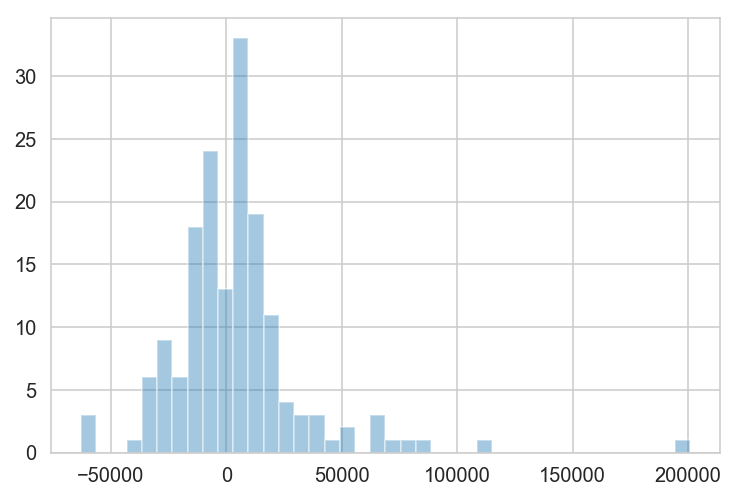

In [127]:
sns.distplot(test_resids, kde=False, bins=40)
plt.show()

Next I will identify features that can be improved by renovations.

In [128]:
renovations = ['RoofStyle','Exterior1st','ExterCond',
              'BsmtCond','HeatingQC','CentralAir','Electrical',
              'GarageFinish','GarageCond','PavedDrive',
              'ExterQual','BsmtQual','GarageQual','KitchenQual',
              'FireplaceQu']
len(renovations)

15

Features referring to 'overall' quality and condition have been omitted as these are too vague.

In [129]:
renovation_f = '~ '+' + '.join(renovations)+' -1'

In [130]:
# Make a predictor matrix from renovation features
X_ren = patsy.dmatrix(renovation_f, data=house, return_type='dataframe')

# Print the shape
print(X_ren.shape)

(1384, 67)


In [131]:
# Standardise the X_ren before splitting into training and test sets
ss = StandardScaler()
Xs_ren = ss.fit_transform(X_ren)

In [132]:
# Create training and test sets
X_ren_train, X_ren_test = Xs_ren[~recent_indices.values], Xs_ren[recent_indices.values]

I used Lasso previously as I wanted to identify the top features and feature elimination helped with this. For this part of the analysis I will use Ridge as I want to keep all the features and instead look to mitigate multicollinearity.

I will first use RidgeCV to find the optimal regularisation strength.

In [133]:
# Define the model
ridge_cv = RidgeCV(alphas=np.logspace(0.1, 1, 300), cv=10)

# Fit the model
ridge_cv.fit(X_ren_train, train_resids)

RidgeCV(alphas=array([ 1.25893,  1.26768, ...,  9.93093, 10.     ]), cv=10,
    fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [134]:
print('The best alpha value was ', ridge_cv.alpha_)

The best alpha value was  10.0


In [135]:
# Calculate the R2 score for the training set
ridge_cv.score(X_ren_train, train_resids)

0.11370387781443303

In [136]:
# Calculate the R2 score for the test set
ridge_cv.score(X_ren_test, test_resids)

0.1160113025472419

The calculated R2 score for both the train and test sets was 0.11 or 11% variance.

Because the R2 score is almost the same for the training and test sets we can say that the model generalises very well out of the sample so despite the score being low we can trust the variance we are explaining.

In [137]:
# Display the features and coefs into a dataframe sorted by magnitude
renovation_coefs = pd.DataFrame(dict(coef=ridge_cv.coef_,
                                     abscoef=np.abs(ridge_cv.coef_),
                                     feature=X_ren.columns))
renovation_coefs.sort_values('abscoef', ascending=False, inplace=True)
renovation_coefs.head(25)

,coef,abscoef,feature
58,-15074.638481,15074.638481,GarageQual[T.TA]
61,-10214.961430,10214.961430,KitchenQual[T.TA]
54,-9569.305492,9569.305492,GarageQual[T.Fa]
23,-8759.213703,8759.213703,ExterCond[T.TA]
60,-7115.036949,7115.036949,KitchenQual[T.Gd]
21,-6622.359972,6622.359972,ExterCond[T.Gd]
44,6609.408675,6609.408675,GarageCond[T.TA]
64,-5313.787271,5313.787271,FireplaceQu[T.None]
66,-4990.440646,4990.440646,FireplaceQu[T.TA]
63,-4639.725679,4639.725679,FireplaceQu[T.Gd]


We are predicting the dollar amount that renovations have on the a house sale. It is important to note that it is in terms of ERRORS of the initial model.

As an example, if the first model overestimated the price for a house, then the error in price (residual) would be negative.

We are predicting those residuals. Luckily, positive and negative still means the same thing. So our 4114coef on Exterior Brick face means that this feature is "worth" 4114 dollars (it is estimated to be 4114 dollars greater).

We can use these features to evaluate how much in dollars a renovation is worth. For example if we wanted to upgrade a kitchen from "fair" (TA) to "good" (Gd) then we would evaluate the differences in their coefficients. The good kitchen is less negative than the average. The difference between them is an estimate of how much value we would gain making that change.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [5]:
# A: